# Test isochrone creation

## Import modules

In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Donwload AOI

<AxesSubplot: >

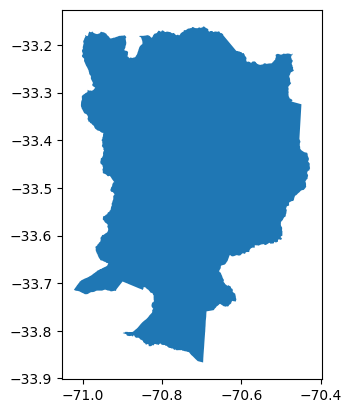

In [2]:
santiago = aup.gdf_from_db('santiago_aoi', 'projects_research')
santiago.plot()

## Donwload edges, nodes and Graph

In [3]:
G,nodes,edges = aup.graph_from_hippo(santiago, 'projects_research', 'santiago_edges',
                    'santiago_nodes')

In [4]:
nodes.shape

(257994, 4)

## Manual isochrone

In [5]:
center_node = nodes.sample(n=1)
center_node = 8870602636
sub_G = nx.ego_graph(G, center_node, radius=500, undirected=True, distance='length')

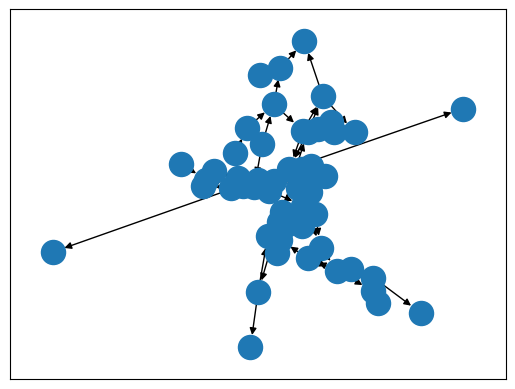

In [6]:
nx.draw_networkx(sub_G, with_labels=False)

### Geometry check

In [7]:
from shapely import Point

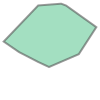

In [8]:
geometry = gpd.GeoSeries([Point((data["x"], data["y"])) for node, data in sub_G.nodes(data=True)]).unary_union.convex_hull
geometry

In [9]:
gdf = gpd.GeoDataFrame()
gdf.loc[0,'geometry'] = geometry

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/pandas/core/indexing.py:1880: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  self.obj[key] = construct_1d_array_from_inferred_fill_value(


In [10]:
gdf = gdf.set_crs("EPSG:4326")

### Save data

In [11]:
gdf.to_file('isochrone_3.geojson')

In [12]:
nodes.loc[nodes.index==center_node].to_file('center_node_3.geojson')

## Function method

In [16]:
import time

In [18]:
start = time.time()
iso_geo = aup.calculate_isochrone(G, center_node, 500, 'length', True)
end = time.time()
print(time)

<module 'time' (built-in)>


In [20]:
print(end-start)

37.58450365066528


## Clip method

In [21]:
import osmnx as ox

In [27]:
start = time.time()

nodes = nodes.to_crs("EPSG:32719")
edges = edges.to_crs("EPSG:32719")

center_node_gdf = nodes.loc[nodes.index==center_node].copy()
buffer = center_node_gdf.buffer(2500)

nodes_buff = gpd.clip(nodes, buffer)
edges_buff = gpd.clip(edges, buffer)

nodes_buff = nodes_buff.to_crs("EPSG:4326")
edges_buff = edges_buff.to_crs("EPSG:4326")

G_buff = ox.graph_from_gdfs(nodes_buff, edges_buff)
iso_geo_buff = aup.calculate_isochrone(G_buff, center_node, 500, 'length', True)

end = time.time()

print(end-start)

/tmp/ipykernel_137433/3877544271.py:15: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  G_buff = ox.graph_from_gdfs(nodes_buff, edges_buff)


2.4400906562805176


### Save to dict

In [33]:
iso_dict = {'osmid':[],
           'geometry':[]}
iso_dict['osmid'].append(center_node)
iso_dict['geometry'].append(iso_geo_buff)

In [34]:
iso_df = pd.DataFrame.from_dict(iso_dict)
iso_gdf = gpd.GeoDataFrame(iso_df, geometry='geometry')

In [35]:
iso_gdf

,osmid,geometry
0,8870602636,"POLYGON ((-70.64576 -33.45695, -70.64690 -33.4..."


In [36]:
iso_gdf = iso_gdf.set_geometry('geometry')
iso_gdf = iso_gdf.set_crs("EPSG:4326")

<AxesSubplot: >

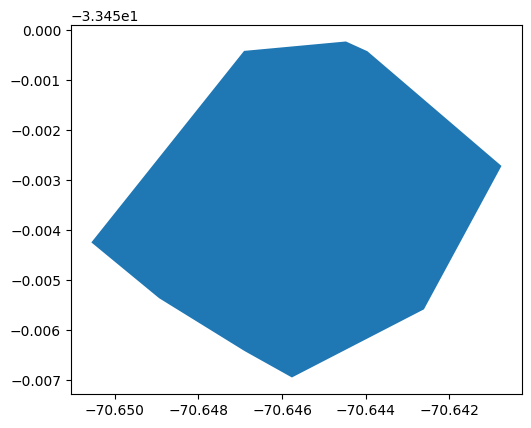

In [37]:
iso_gdf.plot()